In [1]:
pip install pyhepmc numpy hist matplotlib fastjet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 5.9 MB/s eta 0:00:00m eta 0:00:010:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.4/871.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.8/638.8 kB 14.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Processando evento 0...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Processando evento 1000...
Processando evento 2

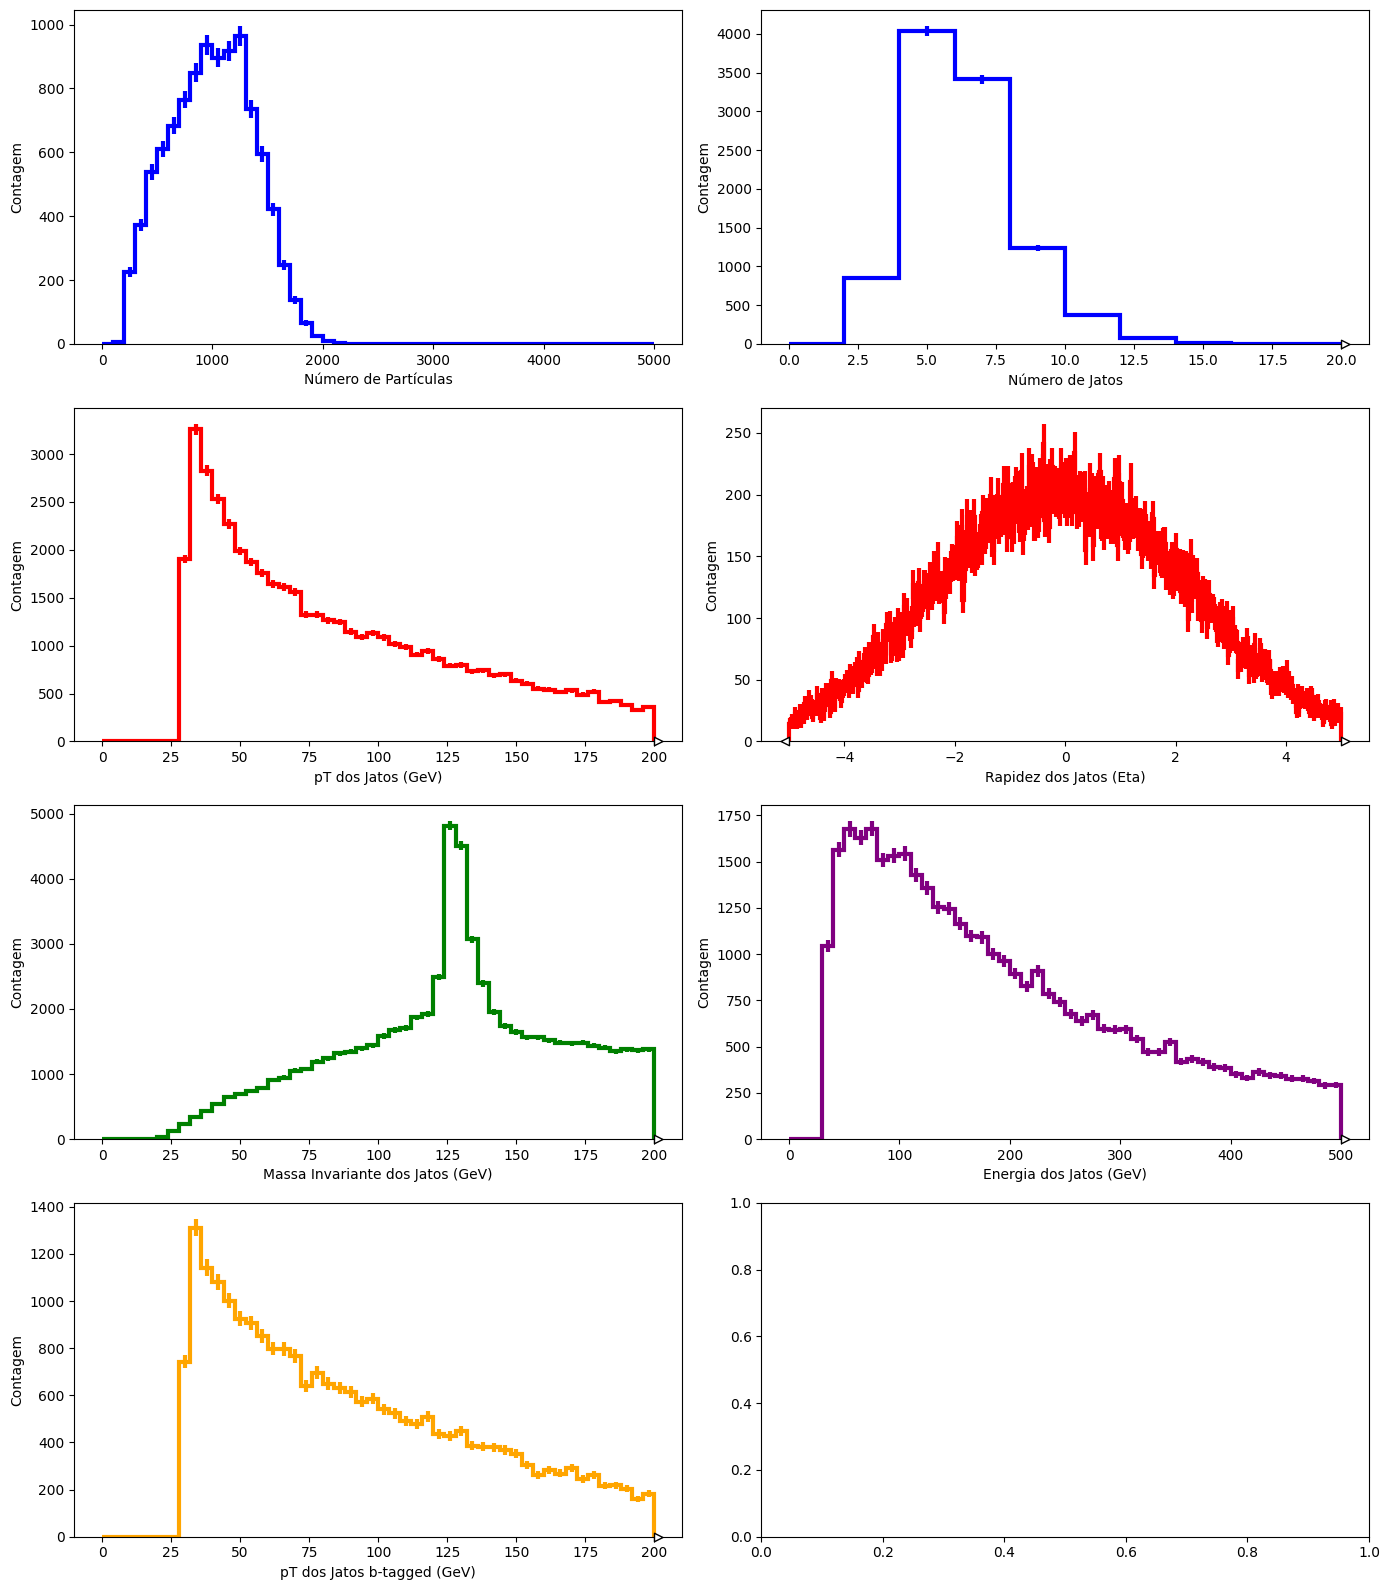

In [1]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'

# Definir histogramas
histo_njets = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_jets_eta = hist.Hist.new.Reg(500, -5., +5.).Double()
histo_jets_mass = hist.Hist.new.Reg(50, 0., 200.).Double()  
histo_npart = hist.Hist.new.Reg(50, 0., 5000.).Double()
histo_jets_energy = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_rjj = hist.Hist.new.Reg(50, 0., 5.0).Double()  
histo_bjets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()

# Função para calcular pseudorapidez (eta)
def get_eta(p):
    ptot = np.sqrt(p.x**2 + p.y**2 + p.z**2)
    if np.isclose(p.z, ptot) or np.isclose(p.z, -ptot):
        return np.nan
    return 0.5 * np.log((ptot + p.z) / (ptot - p.z))

# Função para identificar descendentes de quarks b ao longo da cadeia de decaimento
def get_b_descendants(event):
    b_descendants = []
    for particle in event.particles:
        if abs(particle.pid) == 5:  
            to_process = [particle]
            while to_process:
                current = to_process.pop()
                if current.end_vertex:
                    to_process.extend(current.end_vertex.particles_out)
                b_descendants.append({
                    'eta': get_eta(current.momentum),
                    'phi': np.arctan2(current.momentum.y, current.momentum.x)
                })
    return b_descendants  

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, b_descendants, cone_radius=0.4):
    for b in b_descendants:
        delta_eta = jet.eta() - b['eta']
        delta_phi = np.abs(jet.phi() - b['phi'])
        delta_phi = min(delta_phi, 2 * np.pi - delta_phi)  # Considerar periodicidade de 2π
        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        if delta_r < cone_radius:
            return True
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para calcular a separação angular R entre dois jatos
def delta_r(jet1, jet2):
    delta_eta = jet1.eta() - jet2.eta()
    delta_phi = np.abs(jet1.phi() - jet2.phi())
    delta_phi = min(delta_phi, 2 * np.pi - delta_phi)  
    return np.sqrt(delta_eta**2 + delta_phi**2)

# Processar eventos diretamente do arquivo HEPMC
with hep.open(hepmc_file) as f:
    for ievt, event in enumerate(f):
        if ievt % 1000 == 0:
            print(f"Processando evento {ievt}...")

        # Filtrar partículas finais
        particles = [p for p in event.particles if p.status == 1]

        # Converter partículas para FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]

        # Clustering dos jatos
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        jets = clusterer.inclusive_jets(30.0)

        # Preencher histogramas gerais
        histo_njets.fill(len(jets))
        for jet in jets:
            histo_jets_pt.fill(jet.pt())
            histo_jets_eta.fill(jet.eta())
            histo_jets_energy.fill(jet.e())

        # Massa invariante e separação Rjj
        if len(jets) >= 2:
            for i in range(len(jets) - 1):
                for j in range(i + 1, len(jets)):
                    histo_jets_mass.fill(invariant_mass(jets[i], jets[j]))
                    histo_rjj.fill(delta_r(jets[i], jets[j]))

        # Identificar descendentes de quarks b
        b_descendants = get_b_descendants(event)

        # Jatos b-tagged
        for jet in jets:
            if is_b_tagged(jet, b_descendants):
                histo_bjets_pt.fill(jet.pt())

        # Contagem de partículas
        histo_npart.fill(len(particles))

# Plotar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(4, 2, figsize=(14, 16))

    histo_npart.plot(ax=ax[0, 0], ls="-", color="blue", lw=3)
    ax[0, 0].set(xlabel='Número de Partículas', ylabel='Contagem')

    histo_njets.plot(ax=ax[0, 1], ls="-", color="blue", lw=3)
    ax[0, 1].set(xlabel='Número de Jatos', ylabel='Contagem')

    histo_jets_pt.plot(ax=ax[1, 0], ls="-", color="red", lw=3)
    ax[1, 0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_eta.plot(ax=ax[1, 1], ls="-", color="red", lw=3)
    ax[1, 1].set(xlabel='Rapidez dos Jatos (Eta)', ylabel='Contagem')

    histo_jets_mass.plot(ax=ax[2, 0], ls="-", color="green", lw=3)
    ax[2, 0].set(xlabel='Massa Invariante dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_energy.plot(ax=ax[2, 1], ls="-", color="purple", lw=3)
    ax[2, 1].set(xlabel='Energia dos Jatos (GeV)', ylabel='Contagem')

    histo_bjets_pt.plot(ax=ax[3, 0], ls="-", color="orange", lw=3)
    ax[3, 0].set(xlabel='pT dos Jatos b-tagged (GeV)', ylabel='Contagem')

    plt.tight_layout()
    plt.show()

plot_histograms()


Processando evento 0...
Processando evento 1000...
Processando evento 2000...
Processando evento 3000...
Processando evento 4000...
Processando evento 5000...
Processando evento 6000...
Processando evento 7000...
Processando evento 8000...
Processando evento 9000...


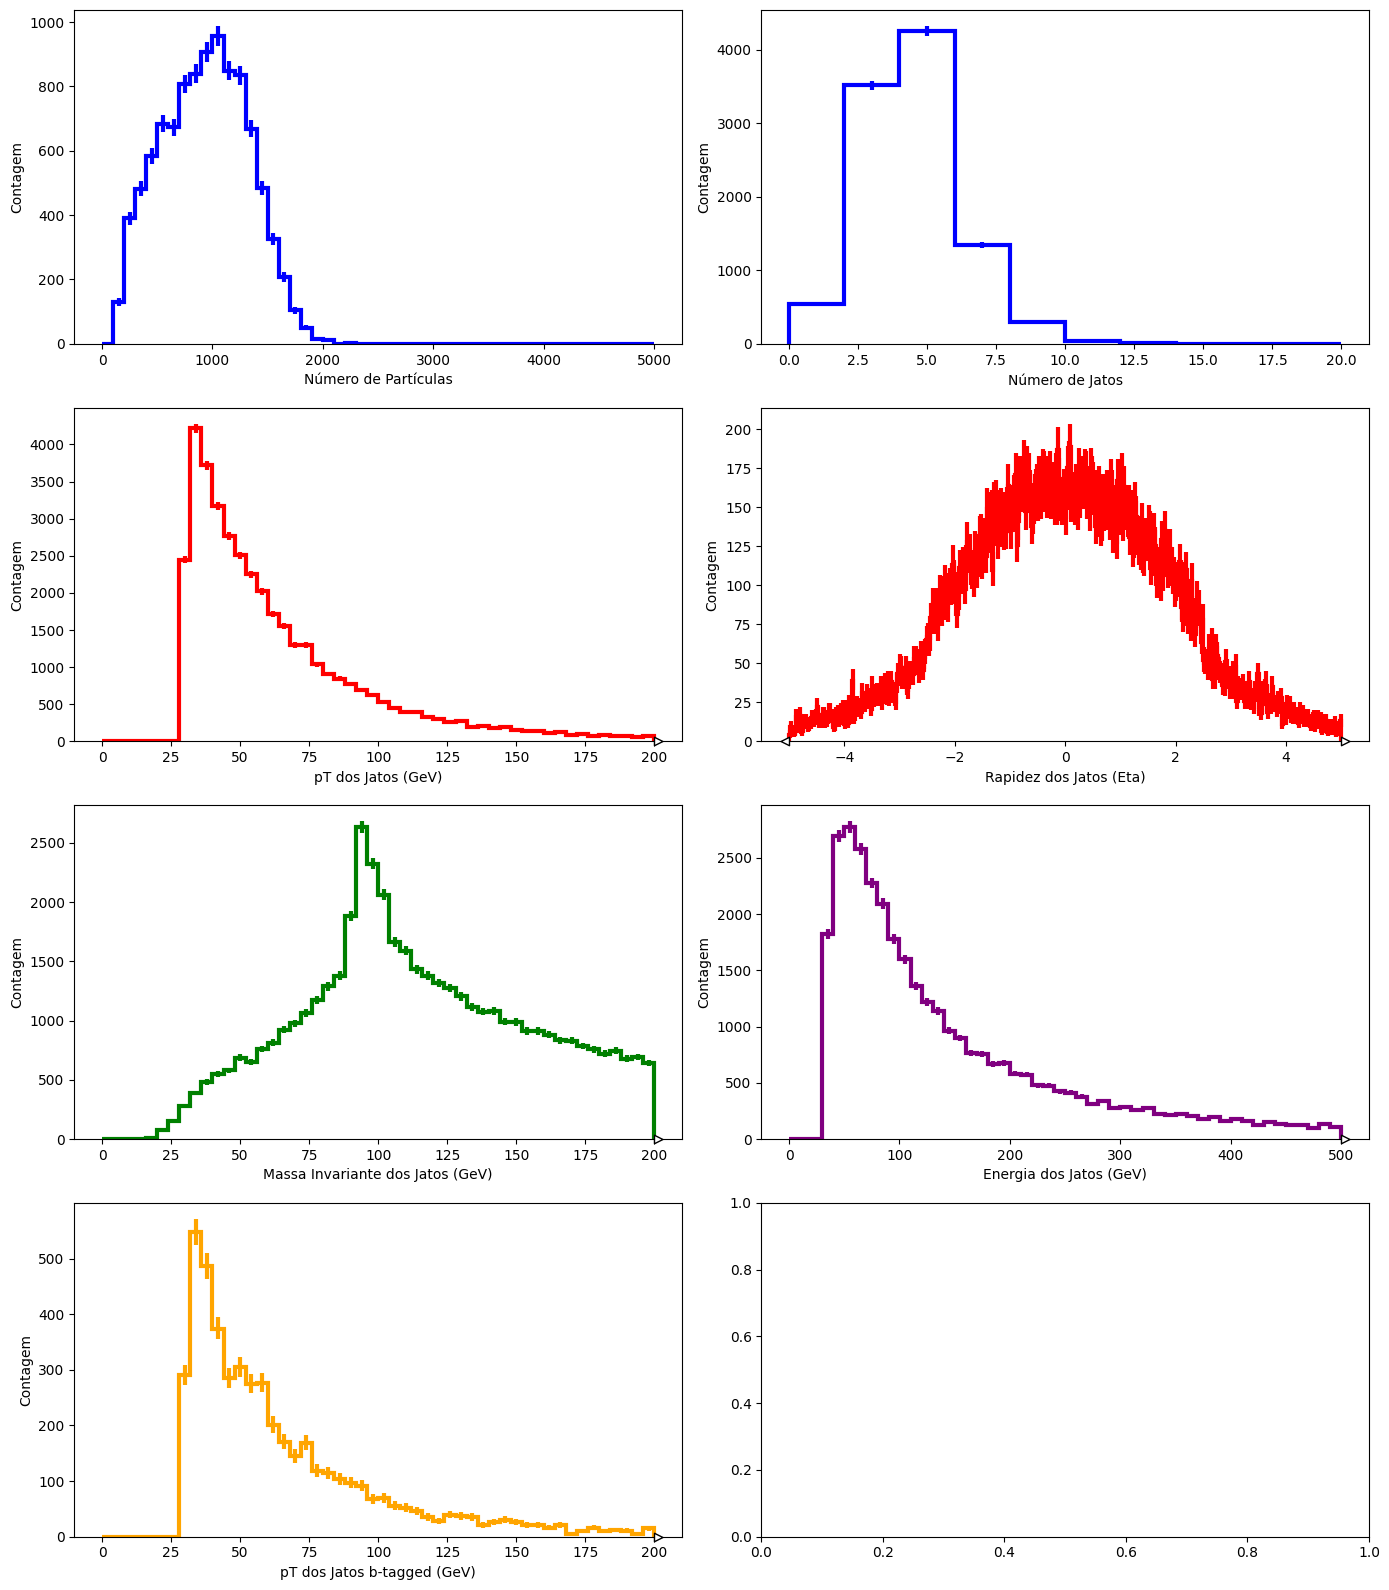

In [2]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Definir histogramas
histo_njets = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_jets_eta = hist.Hist.new.Reg(500, -5., +5.).Double()
histo_jets_mass = hist.Hist.new.Reg(50, 0., 200.).Double()  
histo_npart = hist.Hist.new.Reg(50, 0., 5000.).Double()
histo_jets_energy = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_rjj = hist.Hist.new.Reg(50, 0., 5.0).Double()  
histo_bjets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()

# Função para calcular pseudorapidez (eta)
def get_eta(p):
    ptot = np.sqrt(p.x**2 + p.y**2 + p.z**2)
    if np.isclose(p.z, ptot) or np.isclose(p.z, -ptot):
        return np.nan
    return 0.5 * np.log((ptot + p.z) / (ptot - p.z))

# Função para identificar descendentes de quarks b ao longo da cadeia de decaimento
def get_b_descendants(event):
    b_descendants = []
    for particle in event.particles:
        if abs(particle.pid) == 5:  
            to_process = [particle]
            while to_process:
                current = to_process.pop()
                if current.end_vertex:
                    to_process.extend(current.end_vertex.particles_out)
                b_descendants.append({
                    'eta': get_eta(current.momentum),
                    'phi': np.arctan2(current.momentum.y, current.momentum.x)
                })
    return b_descendants  

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, b_descendants, cone_radius=0.4):
    for b in b_descendants:
        delta_eta = jet.eta() - b['eta']
        delta_phi = np.abs(jet.phi() - b['phi'])
        delta_phi = min(delta_phi, 2 * np.pi - delta_phi)  # Considerar periodicidade de 2π
        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        if delta_r < cone_radius:
            return True
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para calcular a separação angular R entre dois jatos
def delta_r(jet1, jet2):
    delta_eta = jet1.eta() - jet2.eta()
    delta_phi = np.abs(jet1.phi() - jet2.phi())
    delta_phi = min(delta_phi, 2 * np.pi - delta_phi)  
    return np.sqrt(delta_eta**2 + delta_phi**2)

# Processar eventos diretamente do arquivo HEPMC
with hep.open(hepmc_file) as f:
    for ievt, event in enumerate(f):
        if ievt % 1000 == 0:
            print(f"Processando evento {ievt}...")

        # Filtrar partículas finais
        particles = [p for p in event.particles if p.status == 1]

        # Converter partículas para FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]

        # Clustering dos jatos
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        jets = clusterer.inclusive_jets(30.0)

        # Preencher histogramas gerais
        histo_njets.fill(len(jets))
        for jet in jets:
            histo_jets_pt.fill(jet.pt())
            histo_jets_eta.fill(jet.eta())
            histo_jets_energy.fill(jet.e())

        # Massa invariante e separação Rjj
        if len(jets) >= 2:
            for i in range(len(jets) - 1):
                for j in range(i + 1, len(jets)):
                    histo_jets_mass.fill(invariant_mass(jets[i], jets[j]))
                    histo_rjj.fill(delta_r(jets[i], jets[j]))

        # Identificar descendentes de quarks b
        b_descendants = get_b_descendants(event)

        # Jatos b-tagged
        for jet in jets:
            if is_b_tagged(jet, b_descendants):
                histo_bjets_pt.fill(jet.pt())

        # Contagem de partículas
        histo_npart.fill(len(particles))

# Plotar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(4, 2, figsize=(14, 16))

    histo_npart.plot(ax=ax[0, 0], ls="-", color="blue", lw=3)
    ax[0, 0].set(xlabel='Número de Partículas', ylabel='Contagem')

    histo_njets.plot(ax=ax[0, 1], ls="-", color="blue", lw=3)
    ax[0, 1].set(xlabel='Número de Jatos', ylabel='Contagem')

    histo_jets_pt.plot(ax=ax[1, 0], ls="-", color="red", lw=3)
    ax[1, 0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_eta.plot(ax=ax[1, 1], ls="-", color="red", lw=3)
    ax[1, 1].set(xlabel='Rapidez dos Jatos (Eta)', ylabel='Contagem')

    histo_jets_mass.plot(ax=ax[2, 0], ls="-", color="green", lw=3)
    ax[2, 0].set(xlabel='Massa Invariante dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_energy.plot(ax=ax[2, 1], ls="-", color="purple", lw=3)
    ax[2, 1].set(xlabel='Energia dos Jatos (GeV)', ylabel='Contagem')

    histo_bjets_pt.plot(ax=ax[3, 0], ls="-", color="orange", lw=3)
    ax[3, 0].set(xlabel='pT dos Jatos b-tagged (GeV)', ylabel='Contagem')

    plt.tight_layout()
    plt.show()

plot_histograms()


Processando evento 0...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Processando evento 1000...
Processando evento 2

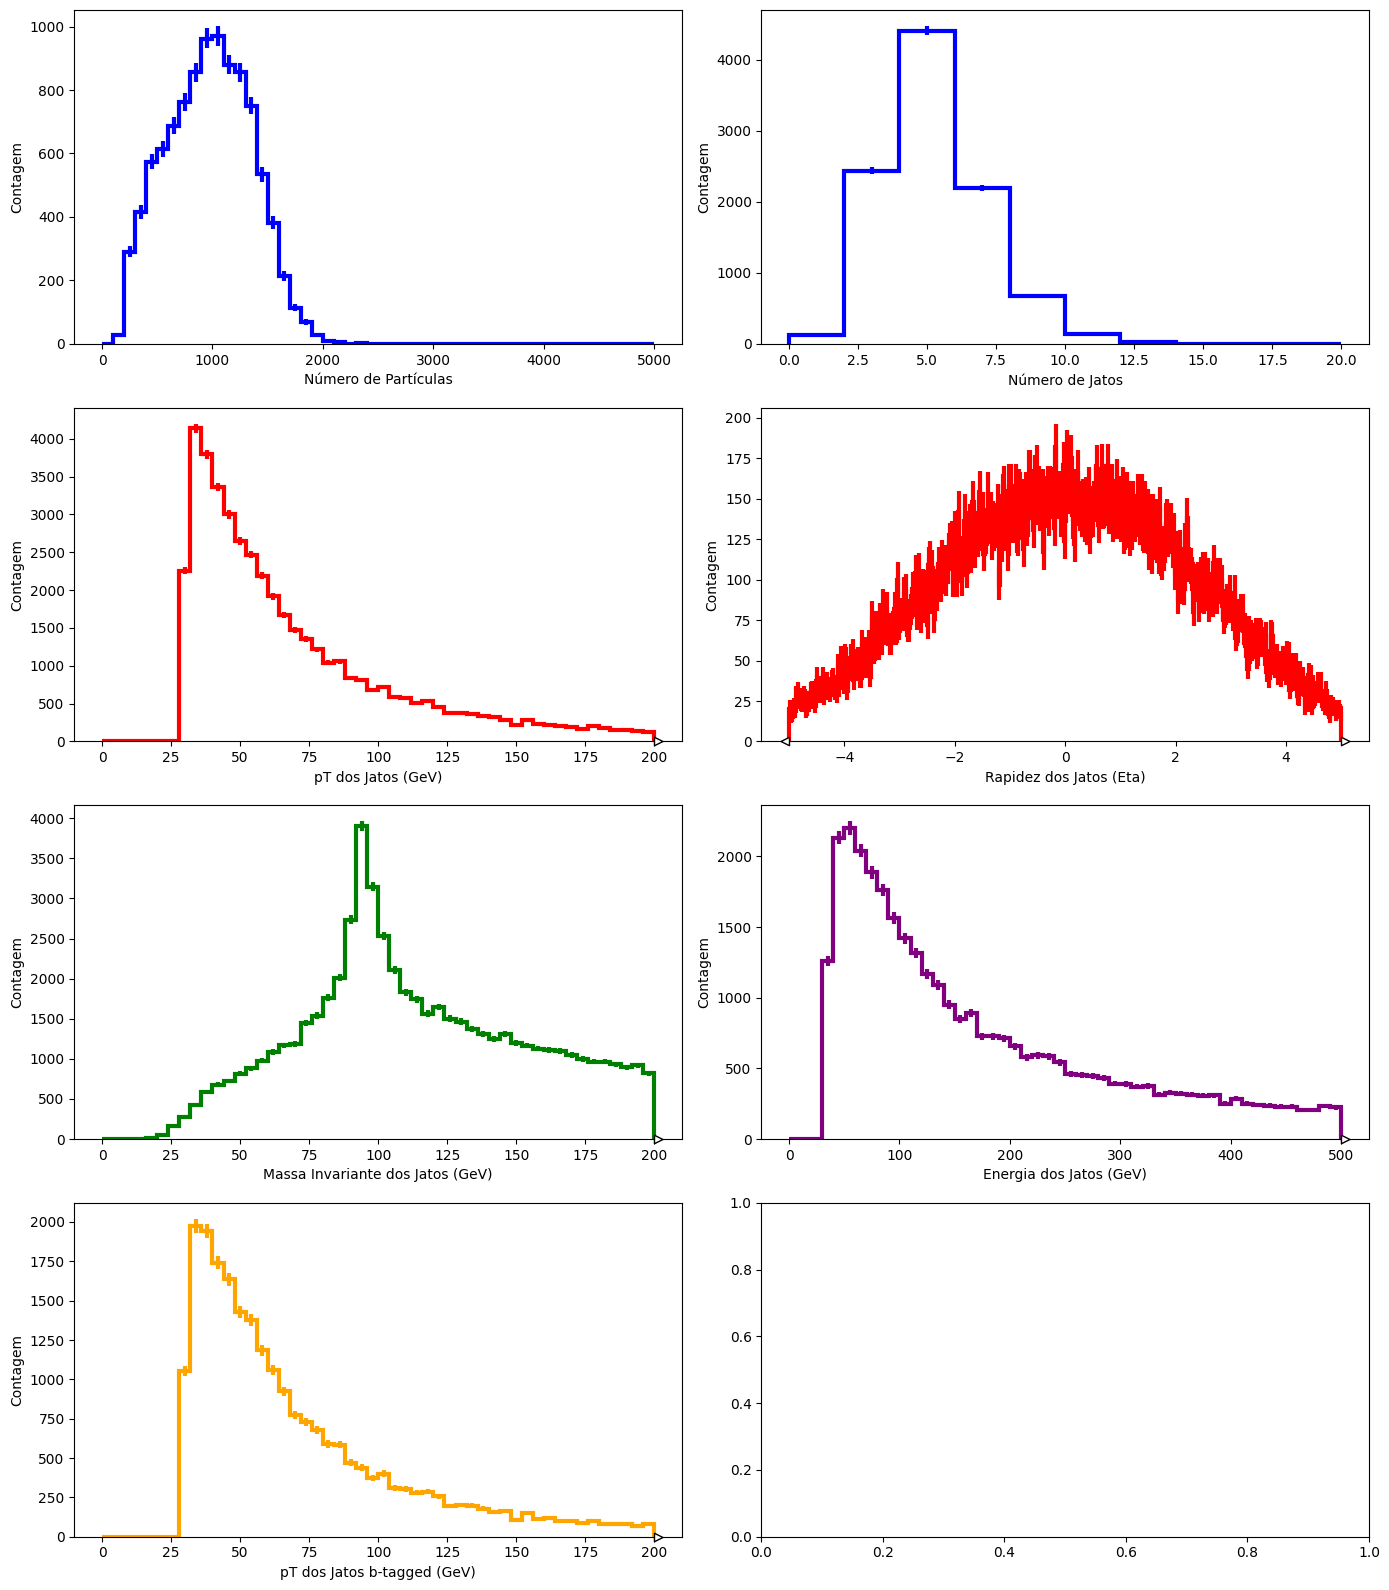

In [1]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_njets = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_jets_eta = hist.Hist.new.Reg(500, -5., +5.).Double()
histo_jets_mass = hist.Hist.new.Reg(50, 0., 200.).Double()  
histo_npart = hist.Hist.new.Reg(50, 0., 5000.).Double()
histo_jets_energy = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_rjj = hist.Hist.new.Reg(50, 0., 5.0).Double()  
histo_bjets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()

# Função para calcular pseudorapidez (eta)
def get_eta(p):
    ptot = np.sqrt(p.x**2 + p.y**2 + p.z**2)
    if np.isclose(p.z, ptot) or np.isclose(p.z, -ptot):
        return np.nan
    return 0.5 * np.log((ptot + p.z) / (ptot - p.z))

# Função para identificar descendentes de quarks b ao longo da cadeia de decaimento
def get_b_descendants(event):
    b_descendants = []
    for particle in event.particles:
        if abs(particle.pid) == 5:  
            to_process = [particle]
            while to_process:
                current = to_process.pop()
                if current.end_vertex:
                    to_process.extend(current.end_vertex.particles_out)
                b_descendants.append({
                    'eta': get_eta(current.momentum),
                    'phi': np.arctan2(current.momentum.y, current.momentum.x)
                })
    return b_descendants  

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, b_descendants, cone_radius=0.4):
    for b in b_descendants:
        delta_eta = jet.eta() - b['eta']
        delta_phi = np.abs(jet.phi() - b['phi'])
        delta_phi = min(delta_phi, 2 * np.pi - delta_phi)  # Considerar periodicidade de 2π
        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        if delta_r < cone_radius:
            return True
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para calcular a separação angular R entre dois jatos
def delta_r(jet1, jet2):
    delta_eta = jet1.eta() - jet2.eta()
    delta_phi = np.abs(jet1.phi() - jet2.phi())
    delta_phi = min(delta_phi, 2 * np.pi - delta_phi)  
    return np.sqrt(delta_eta**2 + delta_phi**2)

# Processar eventos diretamente do arquivo HEPMC
with hep.open(hepmc_file) as f:
    for ievt, event in enumerate(f):
        if ievt % 1000 == 0:
            print(f"Processando evento {ievt}...")

        # Filtrar partículas finais
        particles = [p for p in event.particles if p.status == 1]

        # Converter partículas para FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]

        # Clustering dos jatos
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        jets = clusterer.inclusive_jets(30.0)

        # Preencher histogramas gerais
        histo_njets.fill(len(jets))
        for jet in jets:
            histo_jets_pt.fill(jet.pt())
            histo_jets_eta.fill(jet.eta())
            histo_jets_energy.fill(jet.e())

        # Massa invariante e separação Rjj
        if len(jets) >= 2:
            for i in range(len(jets) - 1):
                for j in range(i + 1, len(jets)):
                    histo_jets_mass.fill(invariant_mass(jets[i], jets[j]))
                    histo_rjj.fill(delta_r(jets[i], jets[j]))

        # Identificar descendentes de quarks b
        b_descendants = get_b_descendants(event)

        # Jatos b-tagged
        for jet in jets:
            if is_b_tagged(jet, b_descendants):
                histo_bjets_pt.fill(jet.pt())

        # Contagem de partículas
        histo_npart.fill(len(particles))

# Plotar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(4, 2, figsize=(14, 16))

    histo_npart.plot(ax=ax[0, 0], ls="-", color="blue", lw=3)
    ax[0, 0].set(xlabel='Número de Partículas', ylabel='Contagem')

    histo_njets.plot(ax=ax[0, 1], ls="-", color="blue", lw=3)
    ax[0, 1].set(xlabel='Número de Jatos', ylabel='Contagem')

    histo_jets_pt.plot(ax=ax[1, 0], ls="-", color="red", lw=3)
    ax[1, 0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_eta.plot(ax=ax[1, 1], ls="-", color="red", lw=3)
    ax[1, 1].set(xlabel='Rapidez dos Jatos (Eta)', ylabel='Contagem')

    histo_jets_mass.plot(ax=ax[2, 0], ls="-", color="green", lw=3)
    ax[2, 0].set(xlabel='Massa Invariante dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_energy.plot(ax=ax[2, 1], ls="-", color="purple", lw=3)
    ax[2, 1].set(xlabel='Energia dos Jatos (GeV)', ylabel='Contagem')

    histo_bjets_pt.plot(ax=ax[3, 0], ls="-", color="orange", lw=3)
    ax[3, 0].set(xlabel='pT dos Jatos b-tagged (GeV)', ylabel='Contagem')

    plt.tight_layout()
    plt.show()

plot_histograms()
